In [122]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sb, string as strings
%matplotlib inline

In [123]:
techcrunch = pd.read_csv('TechCrunch.csv', encoding = 'latin-1')
venturebeat = pd.read_csv('VentureBeat.csv', encoding = 'latin-1')

techcrunch.head()

,title,url,date
0,Gaming firm Razer seeks to raise over $600M in...,https://techcrunch.com/2017/07/01/razer-hong-k...,1-Jul-17
1,Mendel.ai nabs $2 million to match cancer pati...,https://techcrunch.com/2017/07/01/mendel-ai-na...,1-Jul-17
2,These cities in Californias East Bay are raki...,https://techcrunch.com/2017/07/01/these-east-b...,1-Jul-17
3,A walk around Station F with Emmanuel Macron,https://techcrunch.com/2017/07/01/a-walk-aroun...,1-Jul-17
4,Crunch Report | Facebook Helps You Find Wi-Fi,https://techcrunch.com/2017/06/30/crunch-repor...,30-Jun-17


In [124]:
venturebeat.head()

,title,url,date
0,How GameStop is faring as a video game publisher,https://venturebeat.com/2017/02/25/how-gamesto...,2/25/2017 9:10
1,What to expect from the app market this year,https://venturebeat.com/2017/02/25/what-to-exp...,2/25/2017 8:02
2,Six Flags Discovery Kingdoms new roller coast...,https://venturebeat.com/2017/02/25/six-flags-d...,2/25/2017 7:10
3,"Shedding Soviet history, Estonia aims to be wo...",https://venturebeat.com/2017/02/25/__trashed-87/,2/25/2017 6:01
4,Google Assistant picks Arrival for Best Pict...,https://venturebeat.com/2017/02/25/google-assi...,2/25/2017 5:25


In [125]:
techcrunch['date'] = pd.to_datetime(techcrunch['date'], format = '%d-%b-%y', errors = 'coerce')
venturebeat['date'] = pd.to_datetime(venturebeat['date'], errors = 'coerce')

# Clean text
1. Lowercase
2. Remove all punctuation, digits
4. Remove unnecessary long spaces
3. Remove stopwords
4. Remove short 1-2 letter words
4. Position Tagging
5. Lemmatisation

In [130]:
data = pd.concat([techcrunch,venturebeat]).reset_index(drop = True)

In [131]:
data['title'] = data['title'].str.lower().str.replace(r'([{}])'.format(strings.punctuation+''+''), '')

In [132]:
data['title'] = data['title'].str.replace(r'[\d]+','').str.replace('   ',' ').str.replace('  ',' ').str.replace('  ',' ')

In [133]:
data['title'] = data['title'].str.replace(' [\w]{1,2} ', ' ')

In [134]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

In [135]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import nltk

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [136]:
data['title'] = data['title'].str.split(' ').apply(lambda x: [y for y in x if y not in stop])

In [137]:
def tagger(x):
    try:
        return nltk.pos_tag(x)
    except:
        return None

In [138]:
tagged = data['title'].fillna(' ').apply(tagger)

In [139]:
def lemma(t):
    try:
        return [lemmatizer.lemmatize(x[0], get_wordnet_pos(x[1])) for x in t]
    except:
        return []

In [140]:
tagged = tagged.apply(lemma)

In [141]:
tagged = tagged.apply(lambda x: ' '.join(x))

In [142]:
from sklearn.feature_extraction.text import TfidfVectorizer

counter = TfidfVectorizer(ngram_range = (1,2))
counter.fit(tagged)
techC = counter.transform(tagged)

In [147]:
def get_top_words(model, feature_names, n_top_words):
    all_topics = []
    for topic_idx, topic in enumerate(model.components_):
        message = " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        all_topics.append( message)
    return all_topics

In [150]:
from sklearn.decomposition import NMF

topics = NMF(n_components = 20)
topics.fit(techC)
topics_NMF = topics.transform(techC)
topics_NMF = topics_NMF / np.matrix(topics_NMF.sum(1)+np.finfo(float).eps).T
tfidf_feature_names = counter.get_feature_names()
get_top_words(topics, tfidf_feature_names, 10)

['million raise raise million platform series million series million help fund lead funding',
 'google assistant android home google assistant cloud pixel google home google launch get',
 'tech big tech story week european tech big european story week story european top',
 'report crunch crunch report billion uber report uber report google report facebook report apple tesla',
 'game mobile mobile game pc weekly pc game game weekly developer video game studio',
 'live watch right here right here live right day conference stream watch live',
 'new new york york get launch new fund ceo get new feature new ceo',
 'startup battlefield startup battlefield acquire fund invest venture close lead africa',
 'launch service platform launch new google launch spacex in first program microsoft launch',
 'facebook messenger facebook messenger bot news video let fake add test',
 'nintendo switch nintendo switch gamesbeat decides gamesbeat decides come super splatoon roundup',
 'apple iphone apple watc

In [177]:
topics_all = pd.DataFrame(topics_NMF)
topics_all = topics_all.melt()
# topics_all['date'] = dates['value']

In [179]:
dates = data['date']
for x in range(20-1):
    dates = pd.concat([dates,data['date']])

In [181]:
dates = dates.reset_index(drop = True)

In [157]:
topics_all.head()

,variable,value
0,0,0.295297
1,0,0.710517
2,0,0.059623
3,0,0.000000
4,0,0.000000


In [185]:
topics_all.shape

(459120, 3)

In [182]:
topics_all['date'] = dates

In [204]:
T1['date'].dt.all

AttributeError: 'DatetimeProperties' object has no attribute 'all'

TypeError: invalid type promotion

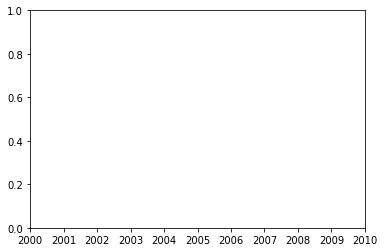

In [201]:
T1 = topics_all.loc[topics_all['variable'] == 0]
plt.scatter(x = T1['date'], y = T1['value'])